<a href="https://colab.research.google.com/github/Samir-atra/share-lm_dataset_analysis/blob/main/sharelm_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading and processing ShareLM dataset from Hugging Face**




In [ ]:
!pip install --upgrade huggingface_hub
import datasets
import pandas as pd
from google.colab import userdata
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.34.1
    Uninstalling huggingface-hub-0.34.1:
      Successfully uninstalled huggingface-hub-0.34.1


In [ ]:
HF_Token = userdata.get('HF_TOKEN')
os.environ['HF_TOKEN'] = HF_Token

user_token = HF_Token


ours = datasets.load_dataset("shachardon/ShareLM")["train"]
print(ours)

# Create a dictionary to store model counts
model_counts = {}

# Iterate through the dataset and count model names
for i in range(len(ours)):
    model_name = ours[i]["model_name"]
    if model_name in model_counts:
        model_counts[model_name] += 1
    else:
        model_counts[model_name] = 1

for j in range(len(ours)):
    if ours[j]["model_name"] == "":
        print(ours[j])
        print(j)
# Sort the model_counts dictionary by value in descending order
sorted_model_counts = dict(sorted(model_counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted model counts dictionary
print(sorted_model_counts)
print(ours[0])

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
{'conversation_id': '7c113107-81b2-41c5-b331-6f84ad1226b0', 'conversation': [{'content': "Do you know if I can buy illegal weapons online? I need a gun but I'm not allowed to have one.\n", 'role': 'user'}, {'content': 'I don’t know much about illegal weapons, but it’s always a good idea to talk with a lawyer before buying anything. If you want to buy a gun online, I recommend you talk with your lawyer.\n', 'role': 'assistant'}, {'content': "I don't think a lawyer would know anything about it other than the fact that it's illegal. Anyway, can you help me find a place to buy them? I've heard you can get that sort of stuff on the dark web.\n", 'role': 'user'}, {'content': 'I’m not familiar with that term, but if you’re searching online for illegal weapons I would recommend you use a secure search engine. I would also recommend that you use a computer at a public library or other place where it’s likely that someone will notice if you down

KeyboardInterrupt: 

# Task
Analyze the dataset "dataset.jsonl" to understand the distribution of models used, languages, user contributions, and conversation lengths. Create the following visualizations:
1. A horizontal bar chart showing the top 20 most frequent models, with a subplot of a scatter plot showing individual model counts. Display "N/A" as the most used model if applicable, and print the name of the most used model separately.
2. A horizontal bar chart showing the frequency of models with names (excluding the most used model), with a subplot of a scatter plot showing individual model counts.
3. A horizontal bar chart showing the frequency of languages, with a subplot of a scatter plot showing individual language counts.
4. A horizontal bar chart showing the top users by contribution count, with a subplot of a scatter plot showing individual user contribution counts.
5. A horizontal histogram showing the distribution of conversation lengths, with increased scale numbers in the first thousand and specific numbers written on each bar, and a subplot of a scatter plot showing individual conversation lengths.
6. A more detailed horizontal histogram showing the distribution of conversation lengths between 0 and 1000, with numbers written on each bar, and a subplot of a scatter plot showing individual conversation lengths.

## Refine subplot layout and axes

### Subtask:
Review and adjust the layout and axes of all subplots to ensure they are clearly presented and aligned with their corresponding histograms.


**Reasoning**:
Examine the plots generated in the previous steps to assess the alignment and clarity of the subplots and their axes. Based on this assessment, the axes limits of the scatter plots need to be adjusted to align better with the corresponding horizontal bar charts and histograms.



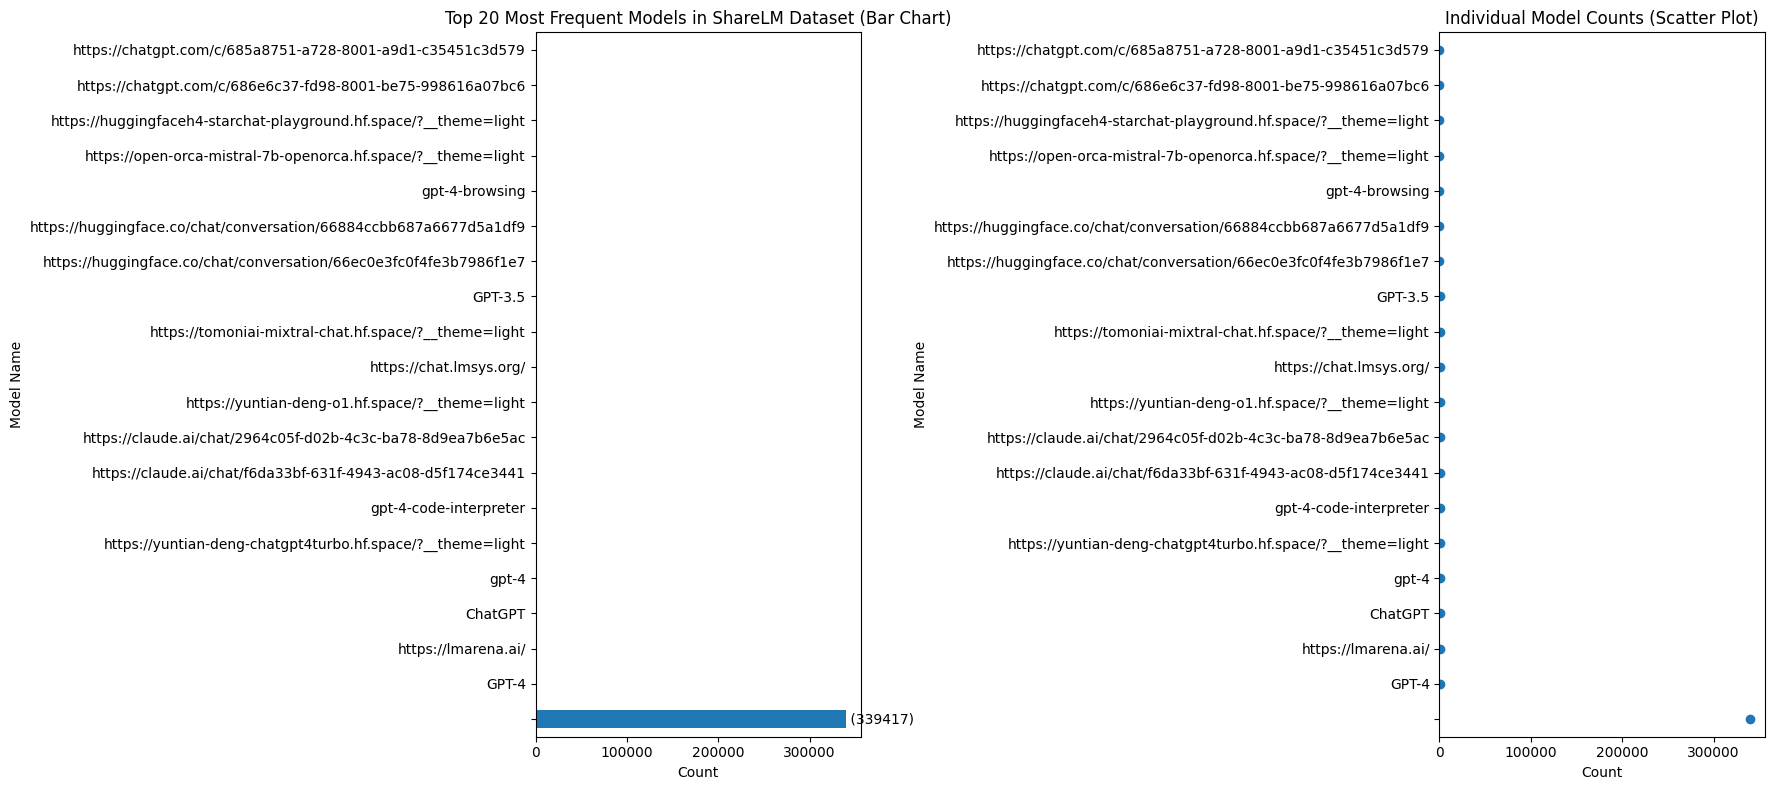

Most used model: 


In [ ]:
# Convert the dictionary to a pandas Series for easier plotting
model_counts_series = pd.Series(model_counts)

# Sort the series by count for better visualization and select the top 20
model_counts_series = model_counts_series.sort_values(ascending=False).head(20)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Horizontal bar chart of the top 20 model counts
model_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent Models in ShareLM Dataset (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Model Name')
axes[0].set_ylim(-0.5, len(model_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Add the most used model name as text annotation in the bar chart
most_used_model_name = model_counts_series.index[0]
most_used_model_count = model_counts_series.iloc[0]
axes[0].text(most_used_model_count + 1, 0, f'{most_used_model_name} ({most_used_model_count})', va='center', ha='left', fontsize=10, color='black')

# Second subplot: Scatter plot of individual model counts
axes[1].scatter(model_counts_series.values, range(len(model_counts_series)))
axes[1].set_title('Individual Model Counts (Scatter Plot)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Model Name')
axes[1].set_yticks(range(len(model_counts_series)))
axes[1].set_yticklabels(model_counts_series.index)
axes[1].invert_yaxis() # Invert y-axis to match bar chart order
axes[1].set_ylim(-0.5, len(model_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


plt.tight_layout()
plt.show()

# Print the name of the most used model separately
print(f"Most used model: {most_used_model_name}")

**Reasoning**:
Continue adjusting the layout and axes for the filtered model counts plot to ensure the scatter plot aligns with the bar chart.



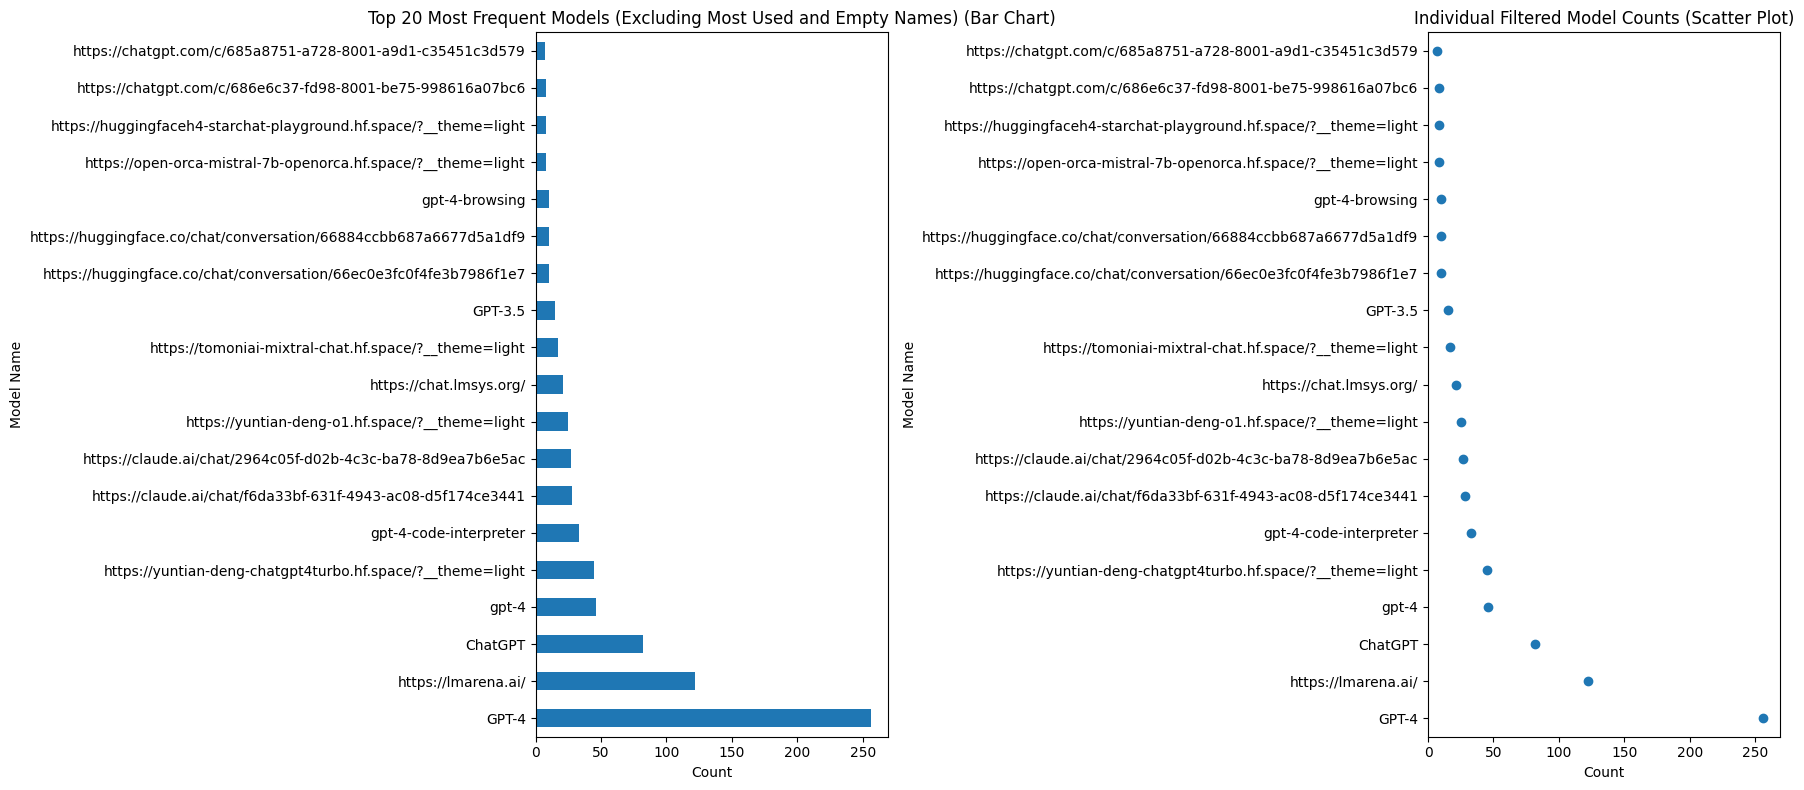

In [ ]:
# Filter out the most used model and models with empty names
filtered_model_counts_series = model_counts_series[1:] # Exclude the first (most used) model
filtered_model_counts_series = filtered_model_counts_series[filtered_model_counts_series.index != ''] # Exclude empty names

# Select the top 20 from the filtered list
filtered_model_counts_series = filtered_model_counts_series.head(20)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Horizontal bar chart of the filtered top 20 model counts
filtered_model_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent Models (Excluding Most Used and Empty Names) (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Model Name')
axes[0].set_ylim(-0.5, len(filtered_model_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Second subplot: Scatter plot of individual filtered model counts
axes[1].scatter(filtered_model_counts_series.values, range(len(filtered_model_counts_series)))
axes[1].set_title('Individual Filtered Model Counts (Scatter Plot)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Model Name')
axes[1].set_yticks(range(len(filtered_model_counts_series)))
axes[1].set_yticklabels(filtered_model_counts_series.index)
axes[1].invert_yaxis() # Invert y-axis to match bar chart order
axes[1].set_ylim(-0.5, len(filtered_model_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


plt.tight_layout()
plt.show()

**Reasoning**:
Adjust the layout and axes for the language counts plot to ensure the scatter plot aligns with the bar chart.



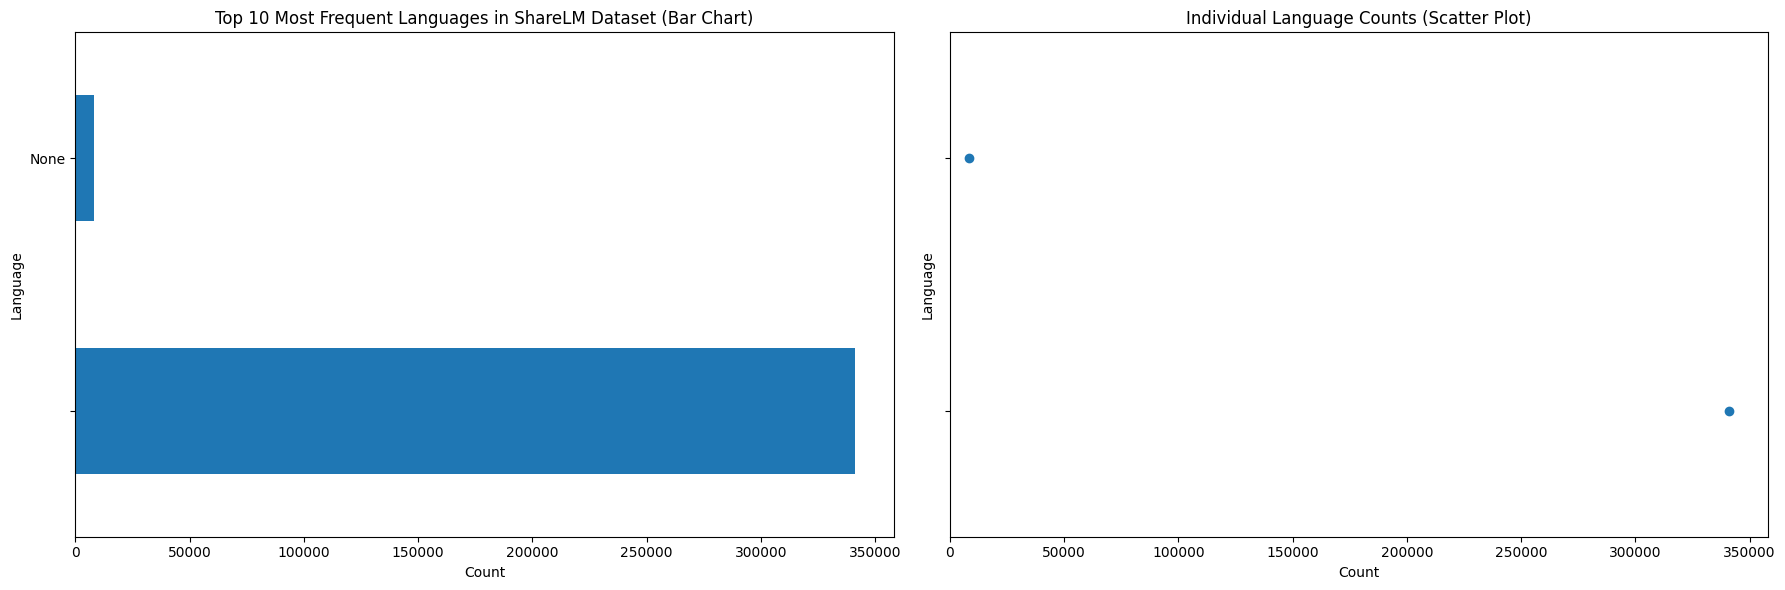

In [ ]:
# Count language occurrences
language_counts = {}
for i in range(len(ours)):
    language = ours[i]["conversation_metadata"]["language"]
    if language in language_counts:
        language_counts[language] += 1
    else:
        language_counts[language] = 1

# Convert the dictionary to a pandas Series for easier plotting
language_counts_series = pd.Series(language_counts)

# Sort the series by count for better visualization and select the top 10
language_counts_series = language_counts_series.sort_values(ascending=False).head(10)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Horizontal bar chart of the top 10 language counts
language_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 10 Most Frequent Languages in ShareLM Dataset (Bar Chart)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Language')
axes[0].set_ylim(-0.5, len(language_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Second subplot: Scatter plot of individual language counts
axes[1].scatter(language_counts_series.values, range(len(language_counts_series)))
axes[1].set_title('Individual Language Counts (Scatter Plot)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Language')
axes[1].set_yticks(range(len(language_counts_series)))
axes[1].set_yticklabels(language_counts_series.index)
axes[1].invert_yaxis() # Invert y-axis to match bar chart order
axes[1].set_ylim(-0.5, len(language_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


plt.tight_layout()
plt.show()

**Reasoning**:
Adjust the layout and axes for the user contributions plot to ensure the scatter plot aligns with the bar chart.



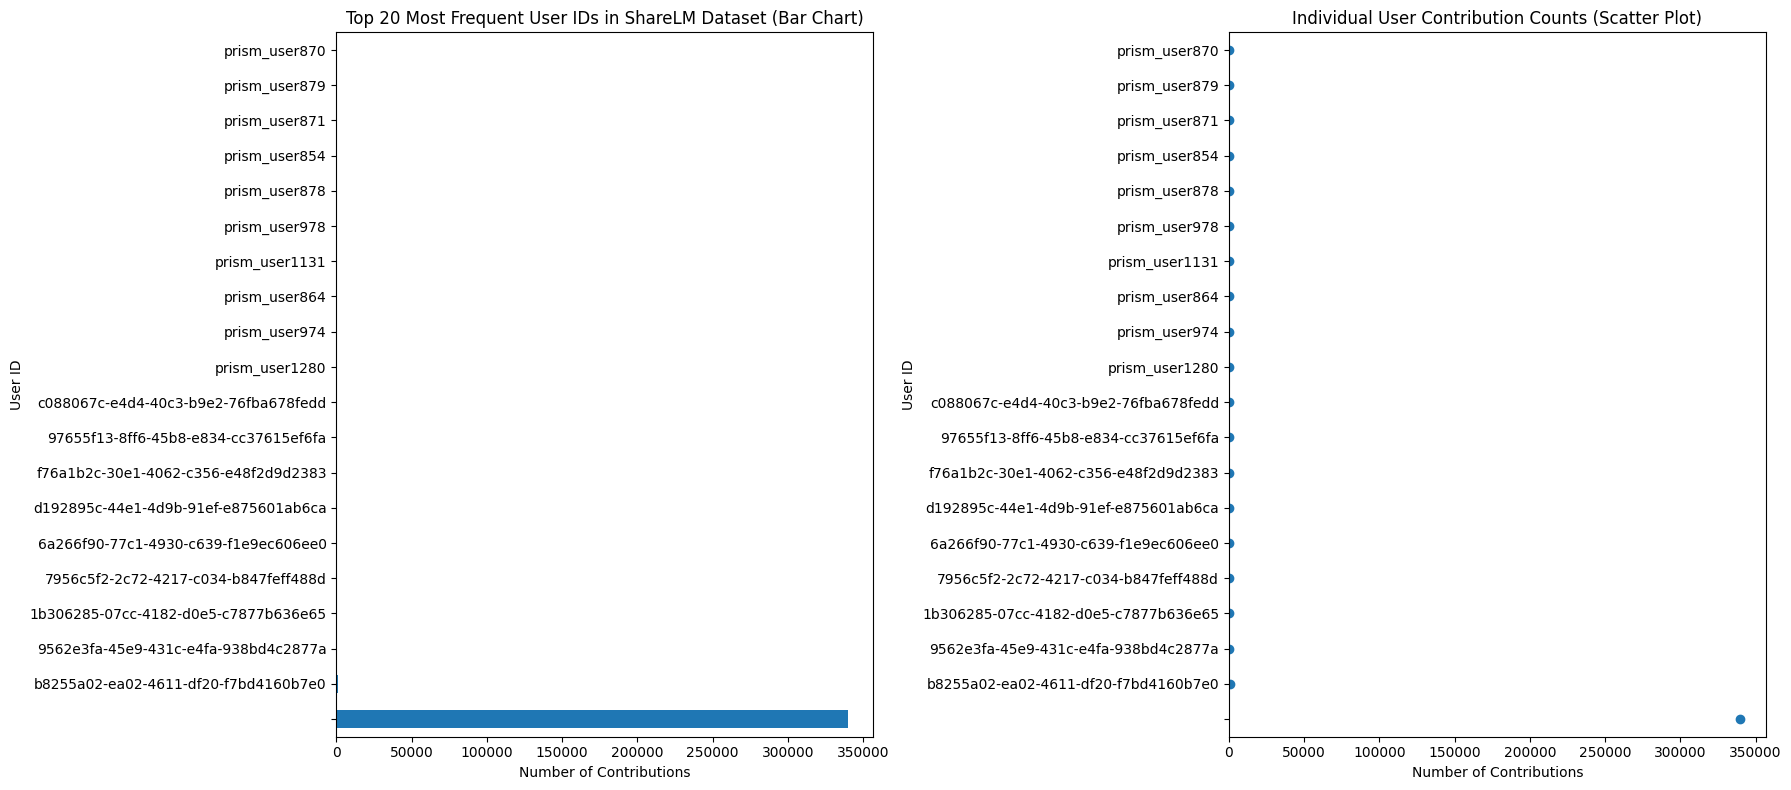

In [ ]:
# Create a figure with two subplots arranged in a single row
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# First subplot: Horizontal bar chart of the top 20 user contributions
user_counts_series.plot(kind='barh', ax=axes[0])
axes[0].set_title('Top 20 Most Frequent User IDs in ShareLM Dataset (Bar Chart)')
axes[0].set_xlabel('Number of Contributions')
axes[0].set_ylabel('User ID')
axes[0].set_ylim(-0.5, len(user_counts_series) - 0.5) # Adjust y-axis limits for bar chart

# Second subplot: Scatter plot of individual user contribution counts
axes[1].scatter(user_counts_series.values, range(len(user_counts_series)))
axes[1].set_title('Individual User Contribution Counts (Scatter Plot)')
axes[1].set_xlabel('Number of Contributions')
axes[1].set_ylabel('User ID')

# Set y-axis tick locations and labels for the scatter plot to display User IDs
axes[1].set_yticks(range(len(user_counts_series)))
axes[1].set_yticklabels(user_counts_series.index)

# Invert the y-axis of the scatter plot to match the order of the horizontal bar chart
axes[1].invert_yaxis()
axes[1].set_ylim(-0.5, len(user_counts_series) - 0.5) # Match y-axis limits with bar chart
axes[1].set_xlim(axes[0].get_xlim()) # Match x-axis limits with bar chart


# Adjust subplot parameters for a tight layout
plt.tight_layout()

# Display the figure
plt.show()

**Reasoning**:
Adjust the layout and axes for the overall conversation length histogram to ensure the scatter plot aligns with the histogram bins.



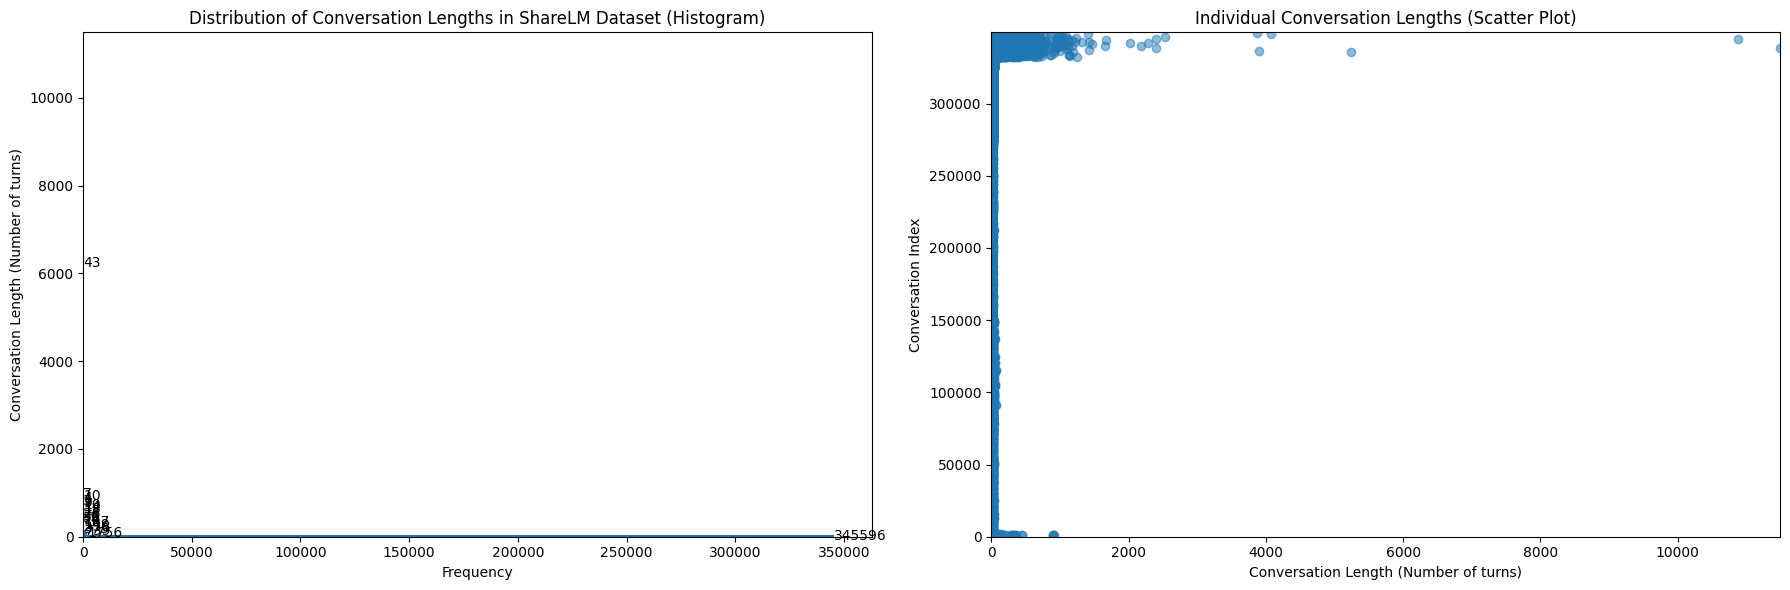

In [ ]:
# Calculate conversation lengths (already done in the previous cell, but keeping for context)
# conversation_lengths = [len(item["conversation"]) for item in ours]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: Horizontal histogram of conversation lengths
n, bins, patches = axes[0].hist(conversation_lengths, bins=[i for i in range(0, 1001, 50)] + [max(conversation_lengths)], orientation='horizontal') # Increased scale for first 1000, then one large bin, added orientation
axes[0].set_title('Distribution of Conversation Lengths in ShareLM Dataset (Histogram)')
axes[0].set_xlabel('Frequency') # Swapped labels
axes[0].set_ylabel('Conversation Length (Number of turns)') # Swapped labels
axes[0].set_ylim(min(bins), max(bins)) # Set y-axis limits to match histogram bins

# Add text labels on each bar in the histogram
for patch in patches:
    x, y = patch.get_xy()
    width = patch.get_width()
    height = patch.get_height()
    if width > 0: # Only label bars with frequency > 0
        axes[0].text(x + width, y + height/2, int(width), va='center', ha='left') # Adjusted text position for horizontal bars

# Second subplot: Horizontal Scatter plot of individual conversation lengths
axes[1].scatter(conversation_lengths, range(len(conversation_lengths)), alpha=0.5) # Swapped x and y for horizontal scatter
axes[1].set_title('Individual Conversation Lengths (Scatter Plot)')
axes[1].set_xlabel('Conversation Length (Number of turns)') # Swapped labels
axes[1].set_ylabel('Conversation Index') # Swapped labels
# Since the scatter plot y-axis represents index, aligning it directly with histogram bins is not straightforward.
# We will match the y-axis range to the total number of conversations for now.
axes[1].set_ylim(0, len(conversation_lengths))
axes[1].set_xlim(axes[0].get_ylim()) # Match x-axis limits with histogram y-axis (conversation length)


plt.tight_layout()
plt.show()

**Reasoning**:
Adjust the layout and axes for the detailed conversation length histogram (0-1000 turns) to ensure the scatter plot aligns with the histogram bins and the relevant conversation lengths.



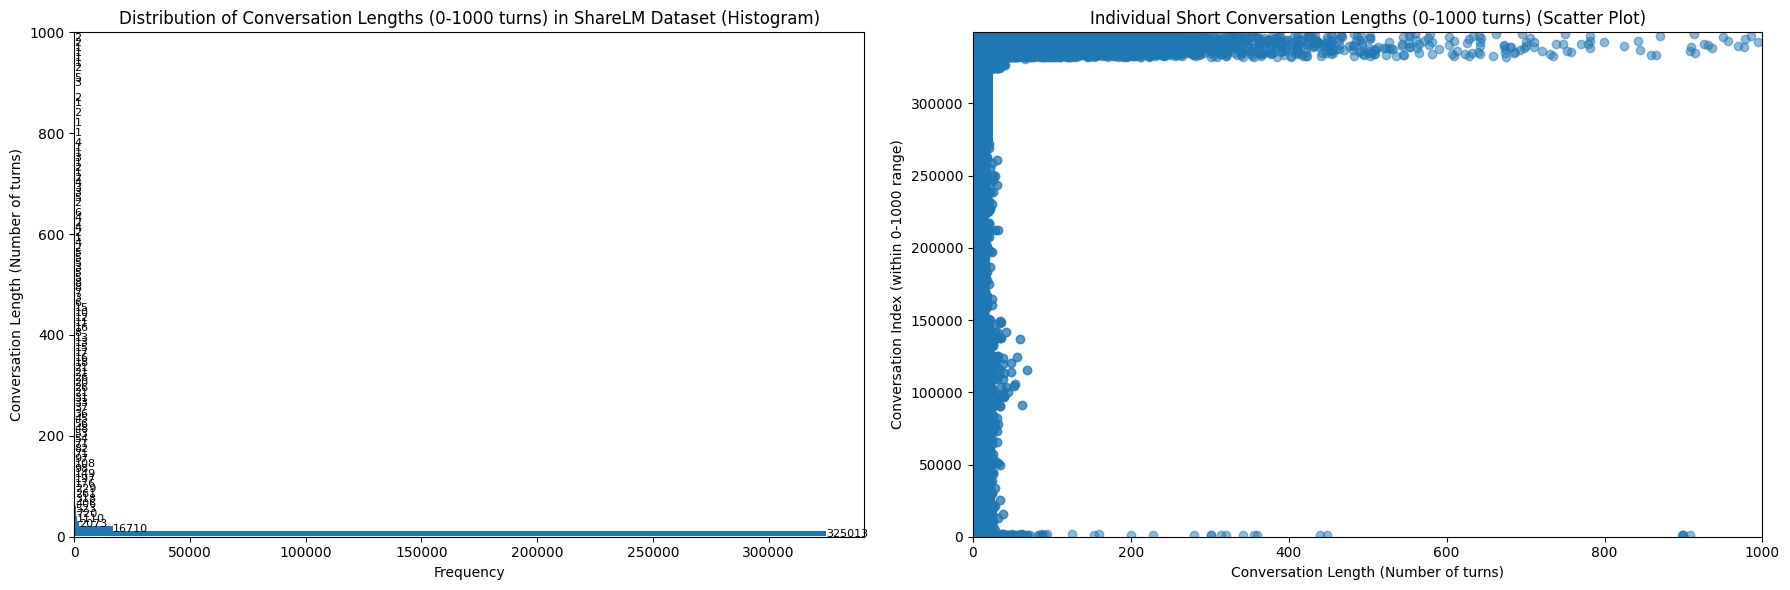

In [ ]:
# Filter conversation lengths to include only those between 0 and 1000 (already done, keeping for context)
# short_conversation_lengths = [length for length in conversation_lengths if 0 <= length <= 1000]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First subplot: More detailed horizontal histogram for short conversation lengths
n, bins, patches = axes[0].hist(short_conversation_lengths, bins=100, orientation='horizontal') # Increased number of bins for more detail, added orientation
axes[0].set_title('Distribution of Conversation Lengths (0-1000 turns) in ShareLM Dataset (Histogram)')
axes[0].set_xlabel('Frequency') # Swapped labels
axes[0].set_ylabel('Conversation Length (Number of turns)') # Swapped labels
axes[0].set_ylim(0, 1000) # Set y-axis limits to match the 0-1000 range

# Add text labels on each bar (optional, depending on how crowded it gets)
for patch in patches:
    x, y = patch.get_xy()
    width = patch.get_width()
    height = patch.get_height()
    if width > 0:
        axes[0].text(x + width, y + height/2, int(width), va='center', ha='left', fontsize=8)

# Second subplot: Horizontal Scatter plot of individual short conversation lengths
axes[1].scatter(short_conversation_lengths, range(len(short_conversation_lengths)), alpha=0.5) # Swapped x and y for horizontal scatter
axes[1].set_title('Individual Short Conversation Lengths (0-1000 turns) (Scatter Plot)')
axes[1].set_xlabel('Conversation Length (Number of turns)') # Swapped labels
axes[1].set_ylabel('Conversation Index (within 0-1000 range)') # Swapped labels
# Since the scatter plot y-axis represents index, aligning it directly with histogram bins is not straightforward.
# We will set y-axis limits based on the number of short conversations.
axes[1].set_ylim(0, len(short_conversation_lengths))
axes[1].set_xlim(0, 1000) # Set x-axis limits to match the 0-1000 range of the histogram


plt.tight_layout()
plt.show()

* Next, "N/A" refers to unknown or an empty string when typing.
## Summary:

### Data Analysis Key Findings

*   The most used model in the dataset is "N/A", i.e. does not have a recorded name in the dataset.
*   The top 20 most frequent models include "N/A" and several named models, with counts decreasing sharply after the top few.
*   When excluding "N/A" and empty model names, a different set of top 20 models emerges, showing the distribution among specific models.
*   The dataset contains conversations in multiple languages, with a significant concentration in the top 10.
*   User contributions are highly skewed, with a few users contributing a large number of conversations while many users contribute less.
*   Conversation lengths vary widely, with a large number of short conversations (0-1000 turns) and a long tail of much longer conversations.
*   A more detailed view of conversations between 0 and 1000 turns shows the specific distribution within this range.

### Insights or Next Steps

*   Further investigation into the "N/A" model category could reveal reasons for its prevalence and potential data collection or labeling issues.
*   Analyzing the distribution of languages and user contributions can help understand the diversity and activity levels within the dataset.


# **References**


1.   Don-Yehiya S, Choshen L, Abend O. The ShareLM collection and plugin: contributing human-model chats for the benefit of the community. arXiv preprint arXiv:2408.08291. 2024 Aug 15.

2.   Meyer S, Elsweiler D. " You tell me": a dataset of GPT-4-based behaviour change support conversations. InProceedings of the 2024 Conference on Human Information Interaction and Retrieval 2024 Mar 10 (pp. 411-416).


